In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo
import scipy.interpolate as itp

import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import axes3d # surface plots
import time as time # for timing later
import glob as glob # for grepping files


from tqdm import tqdm # fancy progress bar

# Data visualisation (first bullet point)
## TASK: Plotting total deposited energy against total track length

Pick a subset of the simulated events and plot a scatter plot of the total deposited energy
against the total track length for the electrons, the photons, and the mystery sample.
What do you observe?

In [2]:
# Defining function to read data files
def readSingleFile(fName):
    eAbs = []
    eGap = []
    lAbs = []
    lGap = []
    aa = np.load(fName)
    eAbs.append(aa[:,0]) # E deposited in Pb plates [MeV]
    eGap.append(aa[:,1]) # E deposited in Ar gas layer [MeV]
    lAbs.append(aa[:,2]) # Total track length in Pb plates [mm]
    lGap.append(aa[:,3]) # Total track length in Ar gas layer [mm]
    
    eAbs = np.squeeze(eAbs)
    eGap = np.squeeze(eGap)
    lAbs = np.squeeze(lAbs)
    lGap = np.squeeze(lGap)
        
    return eAbs, eGap, lAbs, lGap

In [3]:
fDatabase = './lab2data/'
fHighElec = 'RunNtup_HighStatistics_e-_200_Etru_200.00.npy'
fHighGamma = 'RunNtup_HighStatistics_gamma_100_Etru_100.00.npy'
fMys = 'mystery_Etru_-1.00.npy'

eAbsElec, eGapElec, lAbsElec, lGapElec = readSingleFile(fDatabase+fHighElec)
eAbsGamma, eGapGamma, lAbsGamma, lGapGamma = readSingleFile(fDatabase+fHighGamma)
eAbsMys, eGapMys, lAbsMys, lGapMys = readSingleFile(fDatabase+fMys)

Text(0, 0.5, '$E_{Abs}+E_{Gap}$')

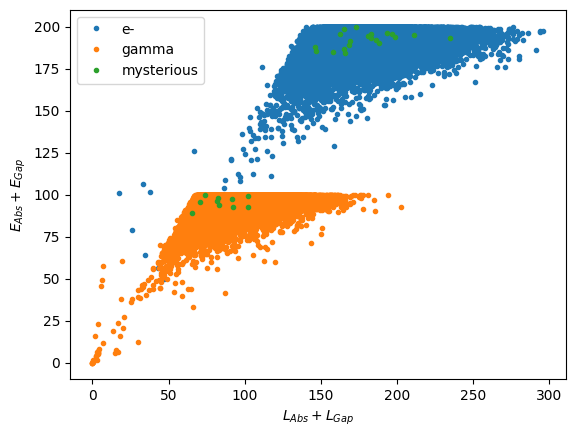

In [4]:
plt.figure()
plt.plot(lAbsElec+lGapElec, eAbsElec+eGapElec, '.', label='e-')
plt.plot(lAbsGamma+lGapGamma, eAbsGamma+eGapGamma, '.', label='gamma')
plt.plot(lAbsMys+lGapMys, eAbsMys+eGapMys, '.', label='mysterious')
plt.legend()
plt.xlabel(r'$L_{Abs}+L_{Gap}$')
plt.ylabel(r'$E_{Abs}+E_{Gap}$')


Electrons and photons can be (roughly) distinguished from one another in this deposited energy vs track length space. Perhaps mystery sample contains a mixture of electrons and photons?

### Opening up files and plotting distributions

In [5]:
def readFileAtE(fBase, E):
    f1000 = glob.glob(fBase+'*'+E+'*.npy')

    fLabel = []
    for ii in f1000:
        sigh = ii.split('RunNtup_')
        sigh = sigh[-1]
        sigh = sigh.split('_'+fE+'_Etru_1000.00.npy')
        fLabel.append(sigh[0])
        
    eAbs = []
    eGap = []
    for iFile in f1000:
        aa = np.load(iFile)
        eAbs.append(aa[:,0]) # energy deposited in absorbing lead plates
        eGap.append(aa[:,1]) # energy deposited in Ar layer
        
    return eAbs, eGap, fLabel

In [6]:
fDatabase = './lab2data/'
#fE = '2000' #'1000'
fE = '1000'

eAbs, eGap, fLabel = readFileAtE(fDatabase, fE)

In [7]:
#eAbs[0]

## TASK:

Can you think of some random distributions you think are
needed to simulate elementary particles?

1. Gaussian (for picking initial energy of particle)
2. Uniform (for picking direction of particle in $\cos(\theta)$ space)
3. Landau (for energy particle deposits in material)

# TASK 3.1
First bullet point

Text(0.5, 0.95, '1000 MeV')

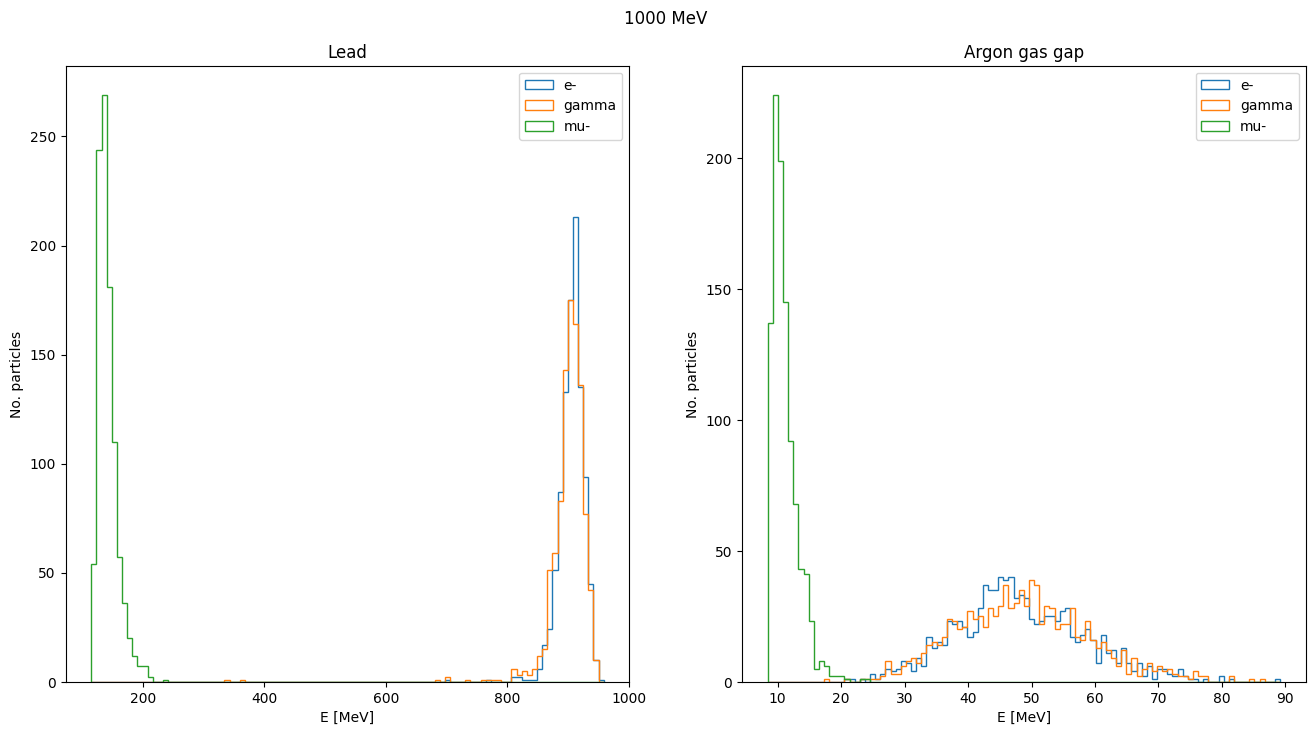

In [8]:
fig = plt.figure(figsize=(16, 8))

# Energy deposited in Lead plates
nBins = 100
lower_edge = []
upper_edge = []
for iPar, locPar in enumerate(fLabel):
    lower_edge.append(min(eAbs[iPar]))
    upper_edge.append(max(eAbs[iPar]))
lower_edge = min(lower_edge)
upper_edge = max(upper_edge)
bin_edges = np.linspace(lower_edge, upper_edge, nBins+1)

ax = fig.add_subplot(121)
for iPar, locPar in enumerate(fLabel):
    plt.hist(eAbs[iPar], bins=bin_edges, histtype='step', label=locPar)
plt.legend()
plt.title('Lead')
plt.xlabel('E [MeV]')
plt.ylabel('No. particles')

# Energy deposited in Argon gas gap
ax = fig.add_subplot(122)
nBins = 100
lower_edge = []
upper_edge = []
for iPar, locPar in enumerate(fLabel):
    lower_edge.append(min(eGap[iPar]))
    upper_edge.append(max(eGap[iPar]))
lower_edge = min(lower_edge)
upper_edge = max(upper_edge)
bin_edges = np.linspace(lower_edge, upper_edge, nBins+1)

for iPar, locPar in enumerate(fLabel):
    plt.hist(eGap[iPar], bins=bin_edges, histtype='step', label=locPar)
plt.legend()
plt.title('Argon gas gap')
plt.xlabel('E [MeV]')
plt.ylabel('No. particles')

plt.suptitle('%s MeV' % fE, y=0.95)

From the above histogram, it is possible to distinguish, by eye, between muons and electrons from their deposition energies in Lead and in Argon gas. Electrons and photons, however, have similar distributions for the deposited energies.

# Task 3.1
Second bullet point: Calculating upper and lower limits of a Poisson distribution

Recall that the probability mass function (PMF) of the Poisson distributions is as follows:
$$
p(k;\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$
where $k$ is the number of occurances/events (ie. the Poisson random variable), and $\lambda$ is the rate parameter.

In [9]:
def calLimPoi(cl, lamb):
    # calculating central limits
    lowQ = (1-cl/100.)/2.
    upQ = 1-lowQ

    smallest_observed = sps.poisson.ppf(lowQ, mu=lamb)
    largest_observed = sps.poisson.ppf(upQ, mu=lamb)
    
    return smallest_observed, largest_observed

In [10]:
maxN = 50 #100
true_lamb = np.linspace(0., maxN, 500)
lowBag = []
upBag = []
cl = 90.

# Stepping through each possible true value of the poisson lamba
# to see what's the smallest and largest observed values are
for this_lamb in true_lamb:
    tmpLow, tmpHigh = calLimPoi(cl, this_lamb)
    
    lowBag.append(tmpLow)
    upBag.append(tmpHigh)

In [11]:
# Interpolating the functions to get the upper and lower limits
# need to flip it x<->y, following lines not buggy
f_poisson_central_ul = itp.interp1d(lowBag, true_lamb, kind='linear')
f_poisson_central_ll = itp.interp1d(upBag, true_lamb, kind='linear')

In [12]:
# Let's say you observed 15
this_observedN = 15

In [13]:
this_LL = f_poisson_central_ll(this_observedN)
this_UL = f_poisson_central_ul(this_observedN)

this_LL, this_UL

(array(10.02004008), array(23.04609218))

Crosschecking with closed form. See eq 40.77a-b https://pdg.lbl.gov/2020/reviews/rpp2020-rev-statistics.pdf for details.

In [14]:
def closed_poisson_ll(n_observed, alpha):
    return 0.5*sps.chi2.ppf(alpha, df=2*n_observed)

def closed_poisson_ul(n_observed, alpha):
    return 0.5*sps.chi2.ppf(1-alpha, df=2*(n_observed+1))

In [15]:
alpha = (1.-cl/100.)/2.
closed_LL = closed_poisson_ll(15, alpha)
closed_UL = closed_poisson_ul(15, alpha)
closed_LL, closed_UL

(np.float64(9.246330490976733), np.float64(23.097129760139236))

(0.0, 30.0)

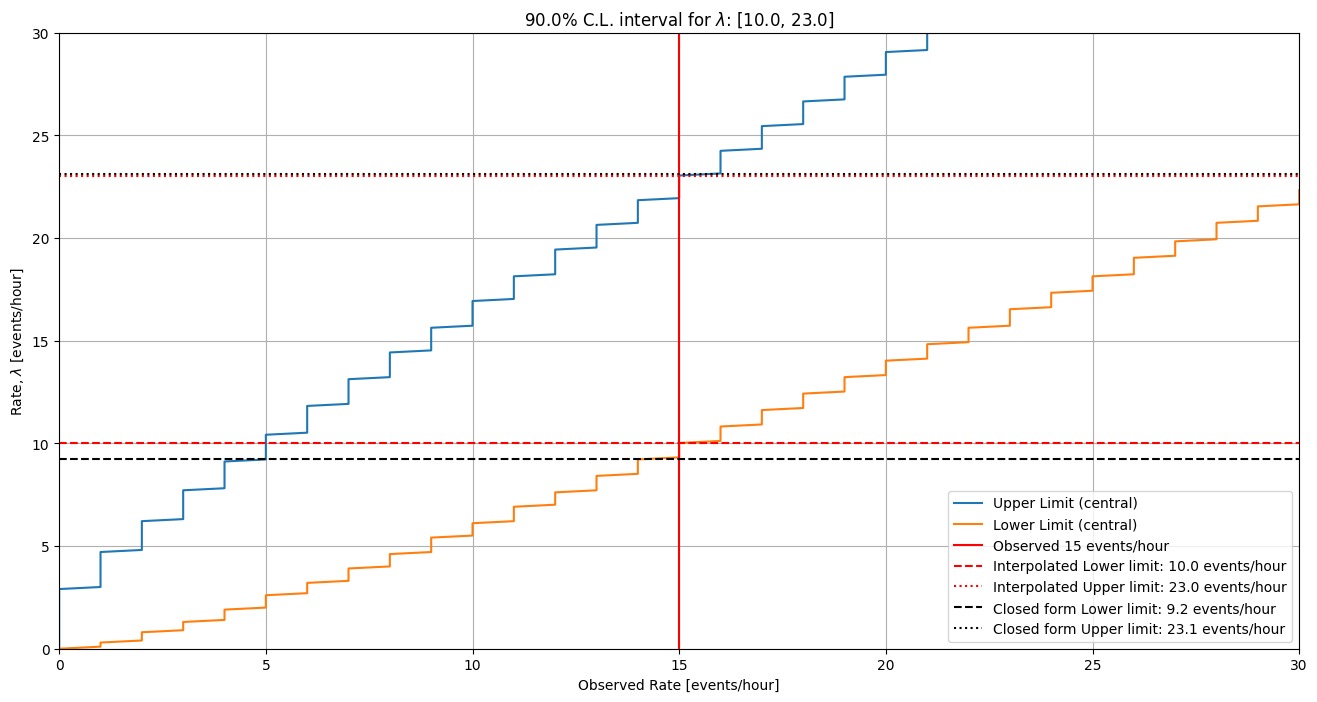

In [16]:
fig = plt.figure(figsize=(16, 8))
plt.plot(lowBag, true_lamb, label='Upper Limit (central)')
plt.plot(upBag, true_lamb, label='Lower Limit (central)')
plt.axvline(this_observedN, c='r', label=f'Observed {this_observedN} events/hour')

plt.axhline(this_LL, c='r', ls='--', label=f'Interpolated Lower limit: {this_LL:.1f} events/hour')
plt.axhline(this_UL, c='r', ls=':', label=f'Interpolated Upper limit: {this_UL:.1f} events/hour')

plt.axhline(closed_LL, c='k', ls='--', label=f'Closed form Lower limit: {closed_LL:.1f} events/hour')
plt.axhline(closed_UL, c='k', ls=':', label=f'Closed form Upper limit: {closed_UL:.1f} events/hour')

plt.xlabel('Observed Rate [events/hour]')
plt.ylabel('Rate, $\lambda$ [events/hour]')
plt.title(f'{cl}% C.L. interval for $\lambda$: [{this_LL:.1f}, {this_UL:.1f}]')

plt.grid()
#plt.minorticks_on()
#plt.grid(b=True, which='major', color='#666666', linestyle='-')
#plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend(loc='lower right')

plt.xlim(0, 30)
plt.ylim(0, 30)

Step-like features of the Neyman band is inevitable because the Poisson random variable is discrete. 

## TASK 3.2 (Estimating electron fraction)
First bullet point: estimate PDF for L_gap for electrons and photons

Text(0.5, 0, '$L_{Gap}$')

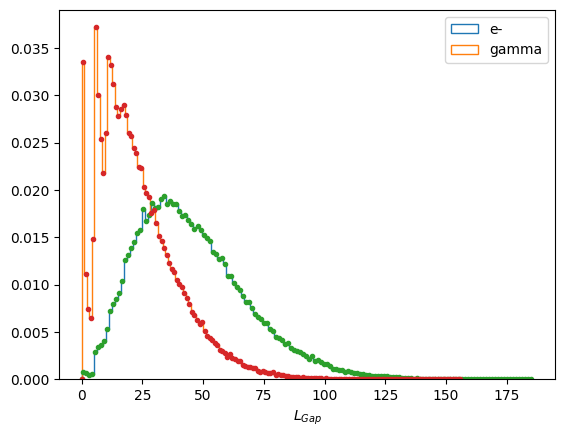

In [17]:
nBins = 150
[nElec, edgesElec, dmp] = plt.hist(lGapElec, bins = nBins, density=True,\
                                   histtype='step', label='e-')
[nGamma, edgesGamma, dmp] = plt.hist(lGapGamma, bins = nBins, density=True, \
                                     histtype='step', label='gamma')
centerElec = (edgesElec[0:-1]+edgesElec[1:])/2.
centerGamma = (edgesGamma[0:-1]+edgesGamma[1:])/2.


centerElec = np.concatenate(([0], centerElec))
nElec = np.concatenate(([0], nElec))
centerGamma = np.concatenate(([0], centerGamma))
nGamma = np.concatenate(([0], nGamma))

# Checking calculation of bin centers
plt.plot(centerElec, nElec, '.')
plt.plot(centerGamma, nGamma, '.')
plt.legend()
plt.xlabel(r'$L_{Gap}$')

### Interpolating the PDFs for $e^-$s and $\gamma$s.

In [18]:
pdfElec = itp.interp1d(centerElec, nElec)
fE = pdfElec(lGapMys)

pdfGamma = itp.interp1d(centerGamma, nGamma)
fG = pdfGamma(lGapMys)

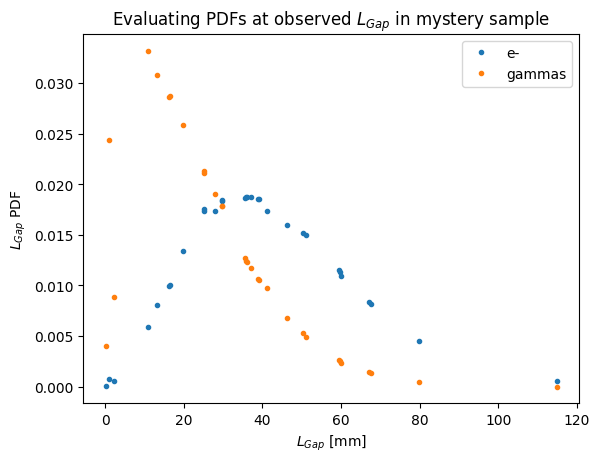

In [19]:
plt.plot(lGapMys, fE, '.', label='e-')
plt.plot(lGapMys, fG, '.', label='gammas')

plt.xlabel(r'$L_{Gap}$ [mm]')
plt.ylabel(r'$L_{Gap}$ PDF')
plt.title('Evaluating PDFs at observed $L_{Gap}$ in mystery sample')
plt.legend()

## TASK 3.2

Second bullet point: Expression for the likelihood, $\cal{L}$,

\begin{align*}
\cal{L} = \Pi_{i} \left[ \frac{n_{\gamma}f^i_{\gamma}+n_{e^-}f^i_{e^-}}{n_{\gamma}+n_{e^-}} P(k=n_{obs}; \lambda=n_{\gamma}+n_{e^-})\right]
\end{align*}

where

$i$ labels each event in the mystery sample,  
$\Pi_{i}$ is the product over all the events,  
$n_{\gamma}$ is the no. of $\gamma$ events,  
$n_{e^-}$ is the no. of $e^-$ events,  
$f^i_{\gamma}(f^i_{e^-})$ is the probability of having a $\gamma(e^-)$ event with $L^i_{gap}$ found in the previous part of this task,  
$P(k=n_{obs}; \lambda=n_{\gamma}+n_{e^-})$ is the Poissonian probability of observing $k=n_{obs}$ events given an expectation $\lambda=n_{\gamma}+n_{e^-}$

The goal is to find the MLE for $n_{\gamma}$ and $n_{e^-}$ from the 2 observables, $L^i_{gap}$ of each event, and the total number of events observed in the mystery sample, $n_{obs}$.

## TASK 3.2
Third bullet point: Constructing the likelihood

In [20]:
def llhCal(params):
    # Function to compute the -loglikelihood
    
    nE = params[0]
    nG = params[1]
    #nE = 10.
    #nG = 4.
    
    nTot = nE+nG
    
    probAtN = sps.poisson.logpmf(np.size(lGapMys), nTot)
    
    # Trying to be funny, but should work in limit of large counts.
    #probAtN = sps.norm.logpdf(np.size(lGapMys), loc=nTot, scale=np.sqrt(nTot))
    
    blah = np.log((nE*fE + nG*fG)/nTot)
    
    llh = -1.*np.sum(blah+probAtN)
    return llh

In [21]:
testEMax = np.size(lGapMys) # If mysterious set consists of all electron events
testGMax = np.size(lGapMys) # If mysterious set consists of all gamma events
testE = range(testEMax)
testG = range(testGMax)

llh = np.zeros((testEMax, testGMax))
for iE in testE:
    for iG in testG:
        llh[iE, iG] = llhCal([iE, iG])

/tmp/ipykernel_6084/337369479.py:16: RuntimeWarning: invalid value encountered in divide
  blah = np.log((nE*fE + nG*fG)/nTot)
/tmp/ipykernel_6084/337369479.py:16: RuntimeWarning: divide by zero encountered in log
  blah = np.log((nE*fE + nG*fG)/nTot)


Text(0, 0.5, 'No. Electrons')

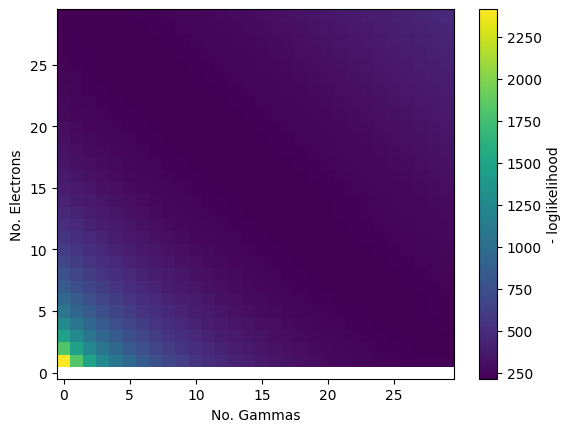

In [22]:
# note that we are minimising this guy, not maximising.
cb = plt.pcolor(testG, testE, llh)
plt.colorbar(cb, norm=mpc.LogNorm, label='- loglikelihood')
plt.xlabel('No. Gammas')
plt.ylabel('No. Electrons')

In [23]:
initGuess = [1, 1]
iAlgo =  'Nelder-Mead' #'TNC'
res = spo.minimize(fun=llhCal,
                   x0=initGuess,
                   method=iAlgo)

In [24]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 216.67590188614648
             x: [ 1.922e+01  1.078e+01]
           nit: 63
          nfev: 120
 final_simplex: (array([[ 1.922e+01,  1.078e+01],
                       [ 1.922e+01,  1.078e+01],
                       [ 1.922e+01,  1.078e+01]]), array([ 2.167e+02,  2.167e+02,  2.167e+02]))

In [25]:
print('Best fit no. electrons = %.3f, Best fit no. gammas = %.3f' % (res.x[0], res.x[1]))
print('Best fit total no. events = %.3f' % np.sum(res.x))

Best fit no. electrons = 19.223, Best fit no. gammas = 10.777
Best fit total no. events = 30.000


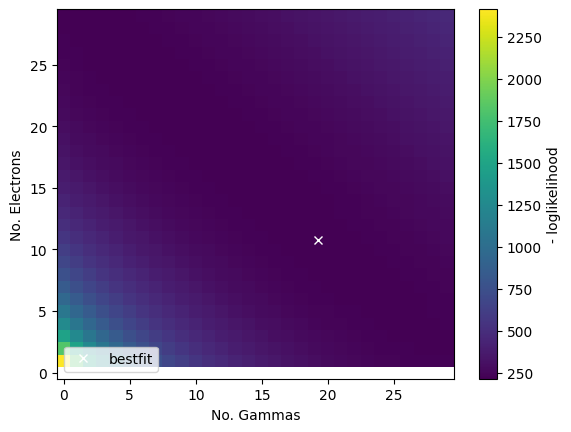

In [26]:
# note that we are minimising this guy, not maximising.
cb = plt.pcolor(testG, testE, llh)
plt.colorbar(cb, norm=mpc.LogNorm, label='- loglikelihood')
plt.plot(res.x[0], res.x[1], 'wx', label='bestfit')
plt.xlabel('No. Gammas')
plt.ylabel('No. Electrons')
plt.legend()